# 1. Data preprocessing

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re

In [2]:
# Read data
df1 = pd.read_json('domain1_train_data.json', lines=True)
df2 = pd.read_json('domain2_train_data.json', lines=True)

# Train dev split
df1_train, df1_dev = train_test_split(df1, stratify=df1['label'], random_state=42)
df2_train, df2_dev = train_test_split(df2, stratify=df2['label'], random_state=42)
dev_set = pd.concat([df1_dev, df2_dev]).reset_index(drop=True)

# Join data in both domains for trating them jointly (Augmentation)
df3_train = pd.concat([df1_train, df2_train]).reset_index(drop=True)

# Transform numbers to strings to treat them as tokens
txt1 = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in df1_train['text']]
txt2 = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in df2_train['text']]
aug_txt = [re.sub(',', '', ', '.join([str(x) for x in tok])) for tok in df3_train['text']]

# Train sets
x_tr1, y_tr1 = txt1, df1_train['label']
x_tr2, y_tr2 = txt2, df2_train['label']
# Train sets (Data Augmentation)
x_tr_aug, y_train_aug = aug_txt, df3_train['label']
# Dev set
x_dev, y_dev = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in dev_set['text']], dev_set['label']

# 2. Encoding

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Tokens encoding to sparce matrix (Countv)
Cvec1 = CountVectorizer()
Cvec2 = CountVectorizer()
Cvec3 = CountVectorizer()

# Vectorize training sets
x_train1_c = Cvec1.fit_transform(x_tr1)
x_train2_c = Cvec2.fit_transform(x_tr2)
x_train_aug_c = Cvec3.fit_transform(x_tr_aug)

# Vectorize development sets
x_dev1_c = Cvec1.transform(x_dev)
x_dev2_c = Cvec2.transform(x_dev)
x_dev_aug_c = Cvec3.transform(x_dev)

In [6]:
# Tokens encoding to sparce matrix (Tfid)
Tvec1 = TfidfVectorizer()
Tvec2 = TfidfVectorizer()
Tvec3 = TfidfVectorizer(sublinear_tf=True, use_idf=True,norm=None)

# Vectorize training sets
x_train1_t = Tvec1.fit_transform(x_tr1)
x_train2_t = Tvec2.fit_transform(x_tr2)
x_train_aug_t = Tvec3.fit_transform(x_tr_aug)

# Vectorize development sets
x_dev1_t = Tvec1.transform(x_dev)
x_dev2_t = Tvec2.transform(x_dev)
x_dev_aug_t = Tvec3.transform(x_dev)

# 3. Train base models (Not NN)

In [7]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
# "default"

# Train models

# Domain 1 models
cl_1_c = LogisticRegression().fit(x_train1_c, y_tr1)
cl_1_t = LogisticRegression().fit(x_train1_t, y_tr1)

# Domain 2 models
cl_2_c = LogisticRegression().fit(x_train2_t, y_tr2)
cl_2_t = LogisticRegression().fit(x_train2_c, y_tr2)

# augmented data (Both domains)
cl_aug_c = LogisticRegression().fit(x_train_aug_c, y_train_aug)
cl_aug_t = LogisticRegression().fit(x_train_aug_t, y_train_aug)
cl_aug_c_w = LogisticRegression(class_weight="balanced").fit(x_train_aug_c, y_train_aug)
cl_aug_t_w = LogisticRegression(class_weight="balanced").fit(x_train_aug_t, y_train_aug)

In [8]:
from sklearn.metrics import accuracy_score
# Accuracy scores
# x_dev, y_dev
# Domain 1 models
sc1_c = cl_1_c.score(x_dev1_c, y_dev)
sc1_t = cl_1_c.score(x_dev1_t, y_dev)
# Domain 2 models
sc2_c = cl_2_c.score(x_dev2_c, y_dev)
sc2_t = cl_2_t.score(x_dev2_t, y_dev)
# Majority voting scores
mv_pred_c = [1 if prob > 0.5 else 0 for prob in (cl_1_c.predict_proba(x_dev1_c).T[1] + cl_2_c.predict_proba(x_dev2_c).T[1])/2]
mv_pred_t = [1 if prob > 0.5 else 0 for prob in (cl_1_t.predict_proba(x_dev1_t).T[1] + cl_2_t.predict_proba(x_dev2_t).T[1])/2]
mv_sc_c = sum([mv_pred_c[i] == y_dev[i] for i, j in enumerate(y_dev)])/len(y_dev)
mv_sc_t = sum([mv_pred_t[i] == y_dev[i] for i, j in enumerate(y_dev)])/len(y_dev)
# Data augmentation scores
sc_aug_c = cl_aug_c.score(x_dev_aug_c, y_dev)
sc_aug_t = cl_aug_t.score(x_dev_aug_t, y_dev)
sc_aug_c_w = cl_aug_c_w.score(x_dev_aug_c, y_dev)
sc_aug_t_w = cl_aug_t_w.score(x_dev_aug_t, y_dev)
# Print scores
print("Accuracy model -MV using  Cvec:", round(mv_sc_c,3))
print("Accuracy model -DA using  Cvec:", round(sc_aug_c,3))
print("Accuracy model -DA using  Cvec-w:", round(sc_aug_c_w,3))
print()
print("Accuracy model -MV using  Tvec:", round(mv_sc_t,3))
print("Accuracy model -DA using  Tvec:", round(sc_aug_t,3))
print("Accuracy model -DA using  Tvec-w:", round(sc_aug_t_w,3))

Accuracy model -MV using  Cvec: 0.651
Accuracy model -DA using  Cvec: 0.846
Accuracy model -DA using  Cvec-w: 0.849

Accuracy model -MV using  Tvec: 0.778
Accuracy model -DA using  Tvec: 0.855
Accuracy model -DA using  Tvec-w: 0.857


              precision    recall  f1-score   support

           0       0.88      0.94      0.90      3500
           1       0.70      0.53      0.61      1000

    accuracy                           0.85      4500
   macro avg       0.79      0.73      0.76      4500
weighted avg       0.84      0.85      0.84      4500



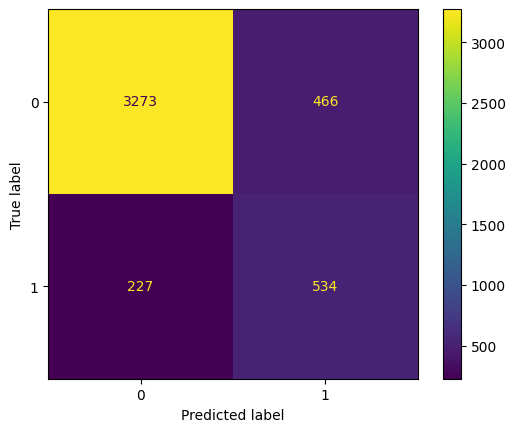

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

C = confusion_matrix(cl_aug_c.predict(x_dev_aug_c), y_dev)
cm = ConfusionMatrixDisplay(confusion_matrix=C)
cm.plot()
print(classification_report(y_dev, cl_aug_c.predict(x_dev_aug_c)))

> The majority voting technique has worse performance than Data Augmentation in all the encoders applied. Thus, for the next steps this is the dataset to use.

# 4 DL Models 

### Embeding model

In [10]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence 

torch.manual_seed(42)

In [11]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

mps


In [12]:
# Truncate sparse matrixes

# Training Cv and Tifd sets
from sklearn.decomposition import TruncatedSVD
x_dense_c = TruncatedSVD(n_components=200).fit_transform(x_train_aug_c.T)
x_dense_t = TruncatedSVD(n_components=200).fit_transform(x_train_aug_t.T)
# Dev sets
dev_dense_c = TruncatedSVD(n_components=200).fit_transform(x_dev_aug_c.T)
dev_dense_t = TruncatedSVD(n_components=200).fit_transform(x_dev_aug_t.T)

In [13]:
# Prepare pytorch dataset
class Dataset(Dataset):
    def __init__(self, text, labels):
        self.text = text
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        text = self.text[idx]
        label = self.labels[idx]
        sample = text, label
        return sample
    
# Define collate (pre_process) function
def collate_batch(batch):  
    texts, labels = zip(*batch)
    texts = torch.tensor(texts, dtype=torch.float32).to(device)
    labels = torch.tensor(labels, dtype=torch.float32).to(device).reshape(-1,1)
    return texts, labels

# Create datasets
train_DS = Dataset(x_dense_t, df3_train['label'])
dev_DS = Dataset(dev_dense_t, dev_set['label'])
# Create dataloaders
x_tr_dl = DataLoader(train_DS, batch_size=100, collate_fn=collate_batch)
x_dev_dl = DataLoader(dev_DS, batch_size=100, collate_fn=collate_batch)

In [14]:
class BowNetwork(torch.nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super().__init__()
        self.first_layer = torch.nn.Linear(vocab_size, hidden_dim) 
        torch.nn.init.uniform_(self.first_layer.weight)
        self.second_layer = torch.nn.Linear(hidden_dim, hidden_dim)
        self.third_layer = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.first_layer(x)) 
        x = torch.relu(self.second_layer(x)) 
        logits = torch.sigmoid(self.third_layer(x))    # logits.shape = [batch_size, 1]
        return logits

In [15]:
vocab_size = x_dense_t.shape[1]
bow_model = BowNetwork(vocab_size, 10).to(device)
print(bow_model)

BowNetwork(
  (first_layer): Linear(in_features=200, out_features=10, bias=True)
  (second_layer): Linear(in_features=10, out_features=10, bias=True)
  (third_layer): Linear(in_features=10, out_features=1, bias=True)
)


In [16]:
from torch.optim.lr_scheduler import CosineAnnealingLR
# Loss fn
loss_fn = torch.nn.BCELoss()
# Optimizer
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=5e-5,
)
# scheduler = CosineAnnealingLR(optimizer, 1)

In [17]:
# Train
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, acc, total = 0, 0, 0
    for X, y in dataloader:
        pred = model(X)             # Forward pass
        loss = loss_fn(pred, y)     # Compute loss 
        loss.backward()             # Backpropagation
        optimizer.step()            # Update parameters
        # scheduler.step()            # Update optimizer
        optimizer.zero_grad()       # Reset gradient
    
        # Metrics
        train_loss += loss.item()
        total += len(y)
        result = (pred>0.5).float()
        acc += (result == y).sum().item()
        
    # General metrics
    train_loss /= total
    acc /= size
    return train_loss, acc

In [18]:
# Test
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, acc, total = 0, 0, 0
    with torch.no_grad():       # Specify no gradient
        for X, y in dataloader:
            pred = model(X)                         # Forward pass
            test_loss += loss_fn(pred, y).item()    # Compute loss     
            
            # Metrics
            result = (pred>0.5).float()             # Results to binary
            acc += (result == y).sum().item()       # Accuracy
            total += len(y)                         # Total observations
            
    # General metrics
    test_loss /= total
    acc /= size
    return test_loss, acc

In [19]:
from tqdm import tqdm, tqdm_notebook # show progress bar

# Epochs
epochs = 50
train_loss, valid_loss = [], []
print("Training BOW feedforward network model!")
for t in range(epochs):
    tl, train_acc = train(x_tr_dl, bow_model, loss_fn, optimizer)
    vl, valid_acc = test(x_dev_dl, bow_model, loss_fn)
    # Losses to dict
    train_loss.append(tl)
    valid_loss.append(vl)
    # Print results
    tqdm.write(
        f'epoch #{t}\ttrain_acc: {train_acc:.3f}\tvalid_acc: {valid_acc:.3f}',
    )

Training BOW feedforward network model!
epoch #0	train_acc: 0.775	valid_acc: 0.774
epoch #1	train_acc: 0.774	valid_acc: 0.774
epoch #2	train_acc: 0.772	valid_acc: 0.774
epoch #3	train_acc: 0.772	valid_acc: 0.773
epoch #4	train_acc: 0.772	valid_acc: 0.774
epoch #5	train_acc: 0.772	valid_acc: 0.774
epoch #6	train_acc: 0.772	valid_acc: 0.773
epoch #7	train_acc: 0.772	valid_acc: 0.773
epoch #8	train_acc: 0.772	valid_acc: 0.773
epoch #9	train_acc: 0.772	valid_acc: 0.773
epoch #10	train_acc: 0.773	valid_acc: 0.774
epoch #11	train_acc: 0.773	valid_acc: 0.774
epoch #12	train_acc: 0.773	valid_acc: 0.773
epoch #13	train_acc: 0.773	valid_acc: 0.774
epoch #14	train_acc: 0.774	valid_acc: 0.774
epoch #15	train_acc: 0.774	valid_acc: 0.774
epoch #16	train_acc: 0.774	valid_acc: 0.774
epoch #17	train_acc: 0.774	valid_acc: 0.774
epoch #18	train_acc: 0.774	valid_acc: 0.774
epoch #19	train_acc: 0.774	valid_acc: 0.774
epoch #20	train_acc: 0.775	valid_acc: 0.774
epoch #21	train_acc: 0.775	valid_acc: 0.774
ep

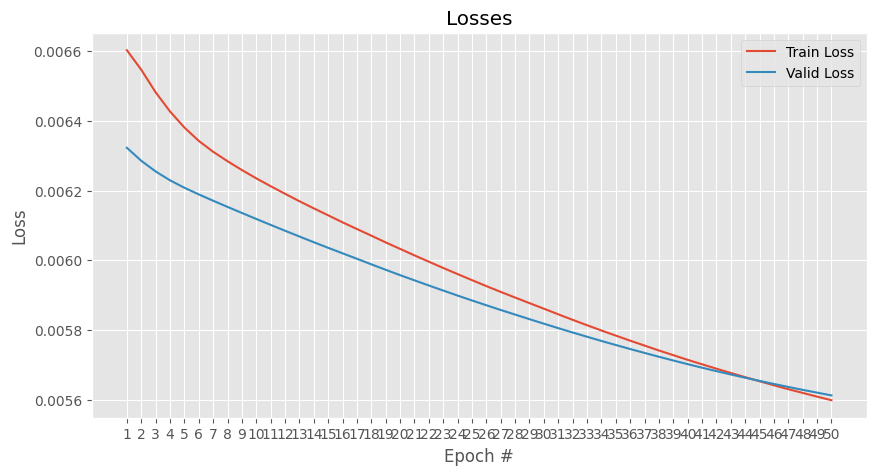

In [20]:
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
epoch_ticks = range(1, epochs + 1)
plt.plot(epoch_ticks, train_loss)
plt.plot(epoch_ticks, valid_loss)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

# RNN Models

In [60]:
# Binary accuracy function
def binary_accuracy(predictions, y):
    rounded_preds = torch.round(torch.sigmoid(predictions)).squeeze()  # Ensure it's a 1D tensor
    correct = (rounded_preds == y).float()
    return correct.sum() / len(correct)


from sklearn.metrics import f1_score

def compute_f1(predictions, labels):
    # Convert predictions to binary
    preds_binary = torch.round(torch.sigmoid(predictions))
    preds_binary = preds_binary.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    return f1_score(labels, preds_binary)

In [107]:
# Prepare pytorch dataset
class Dataset(Dataset):
    def __init__(self, text, labels):
        self.text = text
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        text = torch.tensor(self.text[idx])
        label = torch.tensor(self.labels[idx])
        return text, label
    
# Define collate (pre_process) function
def collate_batch(batch):  
    texts, labels = zip(*batch)
    text_len = [len(txt) for txt in texts]
    # Pad the input sequence to adjust to the largest shape in all the observations
    text = pad_sequence(texts, batch_first=True).to(device) 
    labels = torch.tensor(labels, dtype=torch.float32).to(device).reshape(-1,1)
    return text, labels, text_len

# Create datasets
train_DS = Dataset(df3_train['text'], df3_train['label'])
dev_DS = Dataset(x_dev, y_dev)
# Create dataloaders
x_tr_dl = DataLoader(train_DS, batch_size=100, collate_fn=collate_batch)
x_dev_dl = DataLoader(dev_DS, batch_size=100, collate_fn=collate_batch)

In [109]:
import torch.nn as nn
# Create model
class BILSTM_model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        #Constructor
        super().__init__()
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        #activation function
        self.act = nn.Sigmoid()

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        dense_outputs=self.fc(hidden)
        #Final activation function
        outputs=self.act(dense_outputs)
        return outputs

In [119]:
# Train model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, acc, total, f1 = 0, 0, 0, 0
    for X, y, length in tqdm(dataloader):
        pred = model(X, length)     # Forward pass
        loss = loss_fn(pred, y)     # Compute loss 
        loss.backward()             # Backpropagation
        optimizer.step()            # Update parameters
        # scheduler.step()            # Update optimizer
        optimizer.zero_grad()       # Reset gradient

        # Metrics
        train_loss += loss.item()
        total += len(y)
        acc += binary_accuracy(pred, y).item()
        f1 += compute_f1(pred, y).item()
        
    # General metrics
    train_loss /= total
    acc /= size
    f1/= size
    # return train_loss, acc

# Test model
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, acc, total, f1 = 0, 0, 0, 0
    with torch.no_grad():       # Specify no gradient
        for X, y, length in dataloader:
            pred = pred = model(X, length)          # Forward pass
            test_loss += loss_fn(pred, y).item()    # Compute loss     
            
            # Metrics
            acc += binary_accuracy(pred, y).item()  # Accuracy
            f1 += compute_f1(pred, y).item()
            total += len(y)                         # Total observations
            
    # General metrics
    test_loss /= total
    acc /= size
    return test_loss, acc

In [120]:
#define hyperparameters
size_of_vocab = 100
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = BILSTM_model(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout).to(device)

In [121]:
# Loss fn
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
)
# scheduler = CosineAnnealingLR(optimizer, 1)


In [122]:
from tqdm import tqdm
# Epochs
epochs = 10
train_loss, valid_loss = [], []
print("Training BILSTM neural network model!")
for t in range(epochs):
    tl, train_acc = train(x_tr_dl, model, loss_fn, optimizer)
    vl, valid_acc = test(x_dev_dl, model, loss_fn)
    # Losses to dict
    train_loss.append(tl)
    valid_loss.append(vl)
    # Print results
    tqdm.write(
        f'epoch #{t}\ttrain_acc: {train_acc:.3f}\tvalid_acc: {valid_acc:.3f}',
    )

Training BILSTM neural network model!


100%|██████████| 135/135 [20:45<00:00,  9.22s/it]


TypeError: cannot unpack non-iterable NoneType object

In [46]:
df3_train['text']

0        [15, 128, 9, 728, 99, 31, 20, 402, 24, 58, 133...
1        [16, 1106, 11, 13662, 11783, 25, 2, 1673, 3782...
2        [16, 158, 2915, 5, 2, 341, 6, 497, 118, 10, 2,...
3        [158, 5, 13910, 2134, 16, 2744, 8, 15, 8909, 5...
4        [2, 135, 25, 62, 1511, 12, 1615, 76641, 2, 195...
                               ...                        
13495    [7, 67, 44, 9, 572, 73, 3658, 267, 913, 1750, ...
13496    [2, 363, 342, 3351, 596, 23, 303, 10045, 22, 1...
13497    [8, 15, 71, 12, 864, 7, 69, 6, 63, 3, 29, 201,...
13498    [8, 2, 124, 229, 2361, 4, 1068, 247, 979, 946,...
13499    [7, 7499, 10, 70, 768, 9, 7, 1394, 212, 787, 2...
Name: text, Length: 13500, dtype: object

In [47]:
torch.tensor(df3_train['text'][1])

tensor([   16,  1106,    11, 13662, 11783,    25,     2,  1673,  3782,    98,
           16,    19,   291,   580,   259,   522,    16,  2126,    15,  6757,
            3, 15410, 16915,     4,  5236, 16573,     1,  3855,     3,    16,
           19,   150,  9435,     6,    16,   395,  3782,  3592,  5622,     1,
            1,     1,    40,  3855,    55,    42,    19,   455,    35,     8,
         5184,    30,  4713,    48,    19,    37,   112,   187,     5,   539,
           46,   587, 13934,   127,    34,  2168,    19,    49,  4844,   118,
         3024,    31,   450,    19,    49,  3729,    20,   940,    19,    49,
          190,   333,  2317,   830,    95,  1518,    10, 49366])

In [ ]:
# Save model
torch.save(bow_model.state_dict(), 'models/embeding_ffnn_')

In [ ]:
model = BowNetwork(69661, 10).to(device)
model.load_state_dict(torch.load('models/embeding_ffnn'))

<All keys matched successfully>

In [3]:
import torch
model = torch.jit.load('model_scripted.pt')
model.eval()

NotImplementedError: Could not run 'aten::empty_strided' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::empty_strided' is only available for these backends: [CPU, MPS, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/RegisterCPU.cpp:31357 [kernel]
MPS: registered at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/RegisterMPS.cpp:27248 [kernel]
Meta: registered at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/RegisterMeta.cpp:26984 [kernel]
QuantizedCPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/RegisterQuantizedCPU.cpp:944 [kernel]
BackendSelect: registered at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/RegisterBackendSelect.cpp:807 [kernel]
Python: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:324 [backend fallback]
Named: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ConjugateFallback.cpp:21 [kernel]
Negative: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/NegateFallback.cpp:23 [kernel]
ZeroTensor: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ZeroTensorFallback.cpp:90 [kernel]
ADInplaceOrView: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradCPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradCUDA: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradHIP: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradXLA: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradMPS: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradIPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradXPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradHPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradVE: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradLazy: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradMTIA: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradPrivateUse1: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradPrivateUse2: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradPrivateUse3: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradMeta: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
AutogradNestedTensor: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:19039 [autograd kernel]
Tracer: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/TraceType_2.cpp:17346 [kernel]
AutocastCPU: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:720 [backend fallback]
BatchedNestedTensor: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:746 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:158 [backend fallback]


In [59]:
next(iter(x_tr_dl))[2]

IndexError: tuple index out of range

### Predictions

In [ ]:
test_text = []
text, label = [],[]
with open('test_data.json', 'r') as f:
    for line in f:
        test_text.append(json.loads(line)['text'])
test_text = [', '.join([str(x) for x in tok]) for tok in test_text]

In [ ]:
x_test = vectorizer.transform(test_text).toarray()
test_dataloader = DataLoader(list(zip(x_test,x_test[:][0])), batch_size=batch_size, collate_fn=bow_collate_batch)

In [ ]:
x_tr_aug[1]

'16, 1106, 11, 13662, 11783, 25, 2, 1673, 3782, 98, 16, 19, 291, 580, 259, 522, 16, 2126, 15, 6757, 3, 15410, 16915, 4, 5236, 16573, 1, 3855, 3, 16, 19, 150, 9435, 6, 16, 395, 3782, 3592, 5622, 1, 1, 1, 40, 3855, 55, 42, 19, 455, 35, 8, 5184, 30, 4713, 48, 19, 37, 112, 187, 5, 539, 46, 587, 13934, 127, 34, 2168, 19, 49, 4844, 118, 3024, 31, 450, 19, 49, 3729, 20, 940, 19, 49, 190, 333, 2317, 830, 95, 1518, 10, 49366'